In [5]:
import matplotlib.pyplot as plt
import numpy as np, pickle, cv2
import glob, os
from scipy import stats

from read_data import Subject, SaliencyTrace, FixationAnalyzer

In [6]:
root = "/home/kavra/Datasets/medical/cvi_eyetracking/asc_data_v1/"
trial = "Freeviewingstillimage_1.jpg"

cvi_keys = ['1007_4', '1007_1', '1008_1', '1003_3', '1018_2', '1003_2', '1005_1', '1017_2', '1007_3']
ctrl_keys = ['2003_1', '2002_2', '2002_1', '2004_2', '2004_1', '2006_1']

In [7]:
sub0 = Subject(root, "1003_3")
data0, fr0 = sub0.readTrialData(trial, vel)

In [8]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel"""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(stats.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d / kern2d.sum()

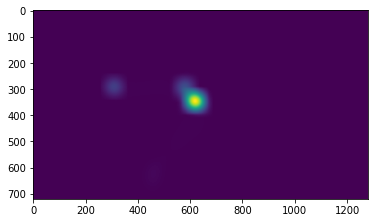

In [9]:
path = glob.glob(f"trials/*/{trial}")[0]
img = cv2.imread(path, cv2.COLOR_BGR2RGB)
out = np.zeros(img.shape[:-1])

k = 101
gaussian_filter = gkern(k, 2)
animation = []
for i in data0:
    x, y = np.array(i, dtype=np.float32)
    x, y = int(x), int(y)
    img_ = cv2.circle(img, (x, y), 10, (255, 0, 0), thickness=2)
    animation.append(img_)
    
    dx = int(k/2)
    l = x - dx
    r = x + dx
    u = y - dx
    d = y + dx
    fl, fr = 0, k
    fu, fd = 0, k

    if l < 0:
        fl = np.abs(l)
        l = 0
    if r >= out.shape[1]:
        fr = (k - 1) * (r - out.shape[1]-1)
        r = out.shape[1]-1
    if u < 0:
        fu = np.abs(u)
        u = 0
    if d >= out.shape[0]:
        fd = (k - 1) * (d - out.shape[0] -1)
        d = out.shape[0]-1

    if out[u:d+1, l:r+1].shape != gaussian_filter[fu:fd+1, fl:fr+1].shape:
        continue
    out[u:d+1, l:r+1] += gaussian_filter[fu:fd+1, fl:fr+1]

plt.imshow(out)

out_path = "./"#"output/fixation_density_new/"
os.makedirs(out_path, exist_ok=True)
plt.imsave(f"{out_path}{trial[:-4]}.png", out)

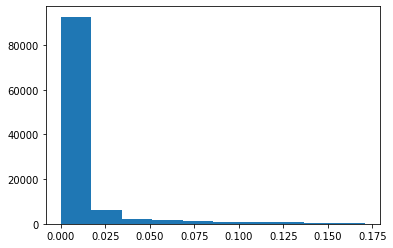

In [6]:
plt.hist(out[out > 0].reshape(-1), 10);

In [36]:
smap = np.load(os.path.join("cvi-extra", "saliency_maps", trial[:-4], trial[:-4] + "_color.npy"))
smap = (smap - np.min(smap))/(np.max(smap) - np.min(smap))

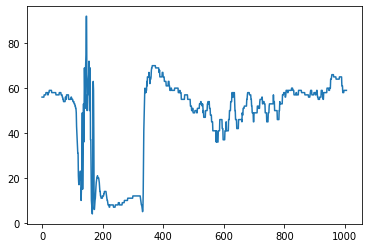

In [7]:
strace = SaliencyTrace(root, smaps=["color", "0"])
sal_track = strace.computeTraces(trial, data0)
plt.plot(sal_track["color"]);

In [ ]:
# TODO: make plot for average fixations
# Perform Mann-Whitney test on CVI - ctrl
# Do the same for average saccades

In [6]:
with open('results/avg_fixation.pkl', 'wb') as f:
    pickle.dump(strace.avg_fixations, f)

{'latency_first_fixation': [0.8916659476046169, 0.3843368580624734],
 'saliency_first_fixation': [-0.7537529164660987, 0.46074452234068153],
 'saliency_longest_fixation': [-0.7656376635654429, 0.45381520122956154],
 'latency_longest_fixation': [0.6789347866046782, 0.5058158936680195],
 'latency_maximum_saliency': [1.378717685683866, 0.18487630911482977]}

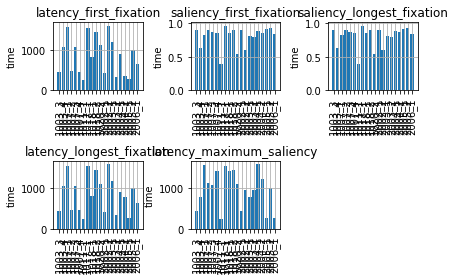

In [3]:
fa = FixationAnalyzer("results", trial)
fa.compute_metrics()

In [4]:
a = [d.rstrip() for d in open('results/ttest_trace_avg.txt')]

trials = [d[:d.index(' Ttest')] for d in a]
stats = [
    float(d[d.index('statistic'):-1].split(',')[0][len('statistic='):]) for d in a
]
pvalues = [
    float(d[d.index('statistic'):-1].split(',')[1][len(' pvalue='):]) for d in a
]

In [12]:
avg_stats = {name: [stat, pvalue] for name, stat, pvalue in zip(trials, stats, pvalues)}

avg_stats_all = {}
for trial, stats in avg_stats.items():
    avg_stats_all[trial] = {}
    avg_stats_all[trial]['avg_saliency'] = stats
    ...

with open('results/stats_all_trials_latency_saliency.pkl', 'wb') as f:
    pickle.dump(avg_stats_all, f)

In [11]:
significance, pv = [], 0.01
for trial, stats in avg_stats_all.items():
    significance.append(
        [
            trial,
            stats['avg_saliency'][1] < pv,
            #stats['latency_first_fixation'][1] < pv,
            #stats['saliency_first_fixation'][1] < pv,
            #stats['saliency_longest_fixation'][1] < pv,
            #stats['latency_longest_fixation'][1] < pv,
            #stats['latency_maximum_saliency'][1] < pv
        ]
    )
print(significance)

[['Freeviewingstillimage_1', False]]
